In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import opendp.prelude as dp
dp.enable_features("contrib")
dp.enable_features("floating-point")

/Users/Ava/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Ava/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# County Level

In [2]:
agg_county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_county_level_all.csv")
county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_county_level_all.csv")

In [3]:
county_categories = agg_county_data_df['County_commute'].unique()
len(county_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

1085

In [4]:
col_names = ["County_commute","County_Origin","County_Destination"]
size = len(county_data_df) #Number of individuals in dataset
county_categories = list(county_categories) #Number of possible categories 


In [5]:
with open('commute_county_level_all.csv') as input_data:
    county_data = input_data.read()

In [6]:
def make_base_laplace_threshold_budget(
    preprocess: dp.Transformation,
    d_in, d_out
) -> dp.Measurement:
    """Make a stability histogram that respects a given d_in, d_out."""
    def privatize(s, t=1e8):
        return preprocess >> dp.m.then_base_laplace_threshold(scale=s, threshold=t)

    s = dp.binary_search_param(lambda s: privatize(s=s), d_in, d_out)
    t = dp.binary_search_param(lambda t: privatize(s=s, t=t), d_in, d_out)

    return privatize(s=s, t=t)

In [7]:
def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    #plt.ylim([0,20000])
    
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #plt.xlim(0,1084)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')

    ax.legend()
    plt.xticks([])  
    plt.title('Histogram of Counts after Stability Histogram for County Level Commute')
    plt.xlabel('Commute')
    plt.ylabel('Count')
    plt.show()

In [22]:
max_influence = 2
epsilon = np.arange(0.5,3.5, 0.5)
budget = [(e, 1e-8) for e in epsilon]

In [23]:
budget[1]

(1.0, 1e-08)

In [24]:
col_names = ["County_commute","County_Origin","County_Destination"]

histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="County_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=county_categories)
)

county_sensitive_counts = histogram(county_data)

In [26]:
# empty dictionary
all_county_released_counts = []
all_county_elapsed_time = []

for epsilon_delta in budget:
    print(epsilon_delta)

    preprocess = (
        dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
        dp.t.make_select_column(key="County_commute", TOA=str) >>
        dp.t.then_count_by(MO=dp.L1Distance[float], TV=float)
    )

    noisy_histogram = make_base_laplace_threshold_budget(
        preprocess,
        d_in=max_influence, d_out=epsilon_delta)

    sensitive_counts = histogram(county_data)

    start_time = time.time()
    released_counts = noisy_histogram(county_data)
    end_time = time.time()

    elapsed_time = end_time - start_time
    all_county_elapsed_time.append(elapsed_time)

    # postprocess to make the results easier to compare
    postprocessed_counts = {k: round(v) for k, v in released_counts.items()}

    all_county_released_counts.append(postprocessed_counts)



#print("Commute level counts:\n", sensitive_counts)
#print("DP Commute level counts:\n", postprocessed_counts)

def as_array(data):
    return [data.get(k, 0) for k in county_categories]

#plot_histogram(sensitive_counts, as_array(released_counts))

(0.5, 1e-08)
(1.0, 1e-08)
(1.5, 1e-08)
(2.0, 1e-08)
(2.5, 1e-08)
(3.0, 1e-08)


In [33]:
as_array(all_county_released_counts[0])

[19174.251833822906,
 959.928858399949,
 548.5342457289757,
 128.5656678766666,
 283.91702908805934,
 1258.2614782318149,
 1510.328425173076,
 984.3572348368812,
 0,
 0,
 956.7793825953913,
 1053.3199789799894,
 0,
 0,
 0,
 83.43166246719272,
 252.33621361240097,
 0,
 0,
 0,
 0,
 1967.646862122715,
 0,
 1635.5685813896935,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 92.92003600178944,
 218857.03967117734,
 15313.318805910656,
 22669.68732550581,
 19236.30832042668,
 3051.562036554953,
 0,
 0,
 1144.8996251880903,
 0,
 0,
 800.8851139335503,
 111.51021129312073,
 108.27312002177118,
 0,
 141.4024333432401,
 0,
 141.06856015753533,
 0,
 0,
 0,
 17954.354294000434,
 171.3862947739683,
 6545.734636127387,
 0,
 370.28799221008967,
 0,
 147.85828636053986,
 0,
 516.3445445267291,
 0,
 0,
 0,
 0,
 0,
 85.00609365543542,
 44130.20302174962,
 80733.32938889303,
 5202.88298778131,
 12760.136552837655,
 4518.36046876772,
 0,
 0,
 562.1001328540578,
 0,
 0,
 815.9284461441794,
 0,
 0,
 0,
 0,
 0,

In [31]:
postprocessed_counts

{'Kildare-Kilkenny': 320,
 'Tipperary-Fingal': 128,
 'Laois-Offaly': 2058,
 'Kildare-Sligo': 37,
 'Galway County-Northern Ireland': 37,
 'Leitrim-Leitrim': 9298,
 'Roscommon-Cork County': 18,
 'Wexford-No fixed place of work': 5905,
 'Cork County-Cork City': 58794,
 'Cavan-Offaly': 15,
 'Wicklow-Kildare': 1786,
 'Mayo-Limerick City and County': 405,
 'Wexford-Wexford': 59950,
 'Westmeath-Mayo': 26,
 'Limerick City and County-Galway County': 119,
 'Offaly-Cork City': 45,
 'Wicklow-Cavan': 17,
 'Westmeath-Laois': 100,
 'Carlow-Meath': 28,
 'Wexford-Kerry': 28,
 'Cork County-No fixed place of work': 16130,
 'Laois-Dún-Laoghaire Rathdown': 496,
 'Tipperary-Laois': 446,
 'Wicklow-Carlow': 966,
 'Donegal-Mayo': 40,
 'Sligo-Galway City': 366,
 'Dublin City-Mayo': 32,
 'Monaghan-Monaghan': 24074,
 'Fingal-Waterford City and County': 43,
 'Leitrim-Limerick City and County': 45,
 'Louth-Dublin City': 4682,
 'Mayo-Meath': 19,
 'Meath-Wicklow': 100,
 'Cavan-Sligo': 188,
 'Carlow-Westmeath': 17,
 '

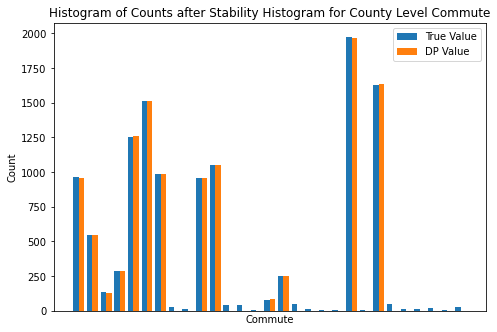

In [34]:
plot_histogram(sensitive_counts[1:30], as_array(all_county_released_counts[0])[1:30])

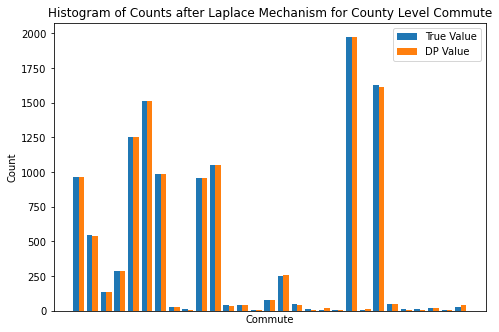

In [10]:
#plot_histogram(county_sensitive_counts[1:30], all_county_released_counts[0][1:30])


In [35]:
def calculate_rmse(predicted_values, actual_values):    
    # Calculate the squared differences
    squared_diffs = np.square(np.array(predicted_values) - np.array(actual_values))
    
    # Calculate the mean of squared differences
    mean_squared_diff = np.mean(squared_diffs)
    
    # Take the square root to get RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse


In [37]:
all_county_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(as_array(all_county_released_counts[released_count]), county_sensitive_counts[:-1])
    all_county_rmse.append(rmse)


In [38]:
all_county_rmse

[23.373779864221643,
 13.043035692374561,
 8.654891292719096,
 6.335945851828107,
 4.9584378643087135,
 4.0525637863161235]

In [50]:
epsilons = [budget[i][0] for i in range(len(budget))]

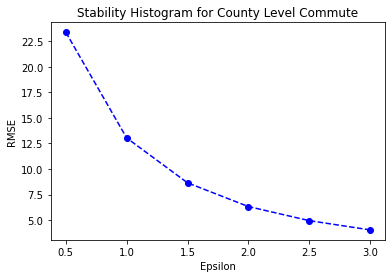

In [51]:
plt.plot(epsilons, all_county_rmse, 'bo')
plt.plot(epsilons, all_county_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Stability Histogram for County Level Commute')
plt.savefig("Stability Histogram for County Level Commute")

In [55]:
#Maximum error 
#FIX AS SENSTIVE COUNTS HAS ONE EXTRA COUNT??
all_county_max_count_difference = []
all_county_max_count_difference_index = []
for released_count in range(len(budget)):
    max_county_count_difference = max(abs(as_array(all_county_released_counts[released_count])[idx] - county_sensitive_counts[idx]) for idx in range(len(county_sensitive_counts)-1))
    all_county_max_count_difference.append(max_county_count_difference)
    county_max_count_difference_index = [idx for idx in range(len(county_sensitive_counts)-1) if abs(as_array(all_county_released_counts[released_count])[idx] - county_sensitive_counts[idx]) == max_county_count_difference]
    all_county_max_count_difference_index.append(county_max_count_difference_index)


In [57]:
all_county_max_count_difference
#[80, 50, 32, 22, 17, 16]
all_county_max_count_difference_index
# [[391, 1017],
#  [45],
#  [866],
#  [661, 999],
#  [27, 194, 426, 432, 590, 652, 719, 839, 895],
#  [160, 240, 411]]

[[391, 1017],
 [45],
 [866],
 [661, 999],
 [27, 194, 426, 432, 590, 652, 719, 839, 895],
 [160, 240, 411]]

In [58]:
county_mean_time  = np.mean(all_county_elapsed_time)
county_mean_time # in seconds 
#4.38883916536967

4.38883916536967

In [59]:
all_county_elapsed_time

# [4.435755014419556,
#  4.38648796081543,
#  4.362583875656128,
#  4.385608196258545,
#  4.365612030029297,
#  4.3969879150390625]

[4.435755014419556,
 4.38648796081543,
 4.362583875656128,
 4.385608196258545,
 4.365612030029297,
 4.3969879150390625]

# ED Level

In [60]:
agg_ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_ed_level_all.csv")
ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_ed_level_all.csv")

In [61]:
ed_categories = agg_ed_data_df['ED_Commute'].unique()
len(ed_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

8699658

In [62]:
col_names = ["ED_commute","ED_Origin","ED_Destination"]
size = len(ed_data_df) #Number of individuals in dataset
ed_categories = list(ed_categories) #Number of possible categories 

In [63]:
with open('commute_ed_level_all.csv') as input_data:
    ed_data = input_data.read()

In [64]:
len(budget)

6

In [65]:
col_names = ["ED_commute","ED_Origin","ED_Destination"]

histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="ED_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=ed_categories)
)

ed_sensitive_counts = histogram(ed_data)


In [67]:
# empty dictionary
all_ed_released_counts = []
all_ed_elapsed_time = []

for epsilon_delta in budget:

    preprocess = (
        dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
        dp.t.make_select_column(key="ED_commute", TOA=str) >>
        dp.t.then_count_by(MO=dp.L1Distance[float], TV=float)
    )

    noisy_histogram = make_base_laplace_threshold_budget(
        preprocess,
        d_in=max_influence, d_out=epsilon_delta)

    sensitive_counts = histogram(ed_data)
    start_time = time.time()
    released_counts = noisy_histogram(ed_data)
    end_time = time.time()
    elapsed_time = end_time - start_time
    all_ed_elapsed_time.append(elapsed_time)

    # postprocess to make the results easier to compare
    postprocessed_counts = {k: round(v) for k, v in released_counts.items()}
    all_ed_released_counts.append(postprocessed_counts)

    print(epsilon_delta)

def as_array(data):
    return [data.get(k, 0) for k in ed_categories]

(0.5, 1e-08)
(1.0, 1e-08)
(1.5, 1e-08)
(2.0, 1e-08)
(2.5, 1e-08)
(3.0, 1e-08)


In [68]:
as_array(all_ed_released_counts[released_count])

[680,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 519,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 22,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 17,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 17,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 68,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 123,
 0,
 31,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [72]:
all_ed_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(as_array(all_ed_released_counts[released_count]), ed_sensitive_counts[:-1])
    all_ed_rmse.append(rmse)


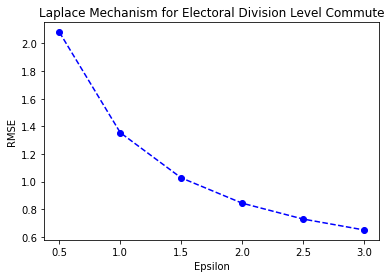

In [73]:
plt.plot(epsilons, all_ed_rmse, 'bo')
plt.plot(epsilons, all_ed_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Laplace Mechanism for Electoral Division Level Commute')
plt.savefig("Laplace Mechanism for Electoral Division Level Commute")


In [74]:
#Maximum error 
all_ed_max_count_difference = []
all_ed_max_count_difference_index = []
for released_count in range(len(budget)):
    max_ed_count_difference = max(abs(as_array(all_ed_released_counts[released_count])[idx] - ed_sensitive_counts[idx]) for idx in range(len(ed_sensitive_counts)-1))
    all_ed_max_count_difference.append(max_ed_count_difference)
    ed_max_count_difference_index = [idx for idx in range(len(ed_sensitive_counts)-1) if abs(as_array(all_ed_released_counts[released_count])[idx] - ed_sensitive_counts[idx]) == max_ed_count_difference]
    all_ed_max_count_difference_index.append(ed_max_count_difference_index)


KeyboardInterrupt: 

In [46]:
all_ed_max_count_difference
#[57, 32, 21, 16, 12, 10, 10, 8, 7, 6]
#all_ed_max_count_difference_index
# [[7890592],
#  [8426434],
#  [1638498],
#  [573781],
#  [691995, 3917674],
#  [5692415, 7269616],
#  [704791, 4168329, 4707089],
#  [5636043],
#  [2651429, 6328040],
#  [2327384, 2887713, 5594075, 5839875]]

[[7890592],
 [8426434],
 [1638498],
 [573781],
 [691995, 3917674],
 [5692415, 7269616],
 [704791, 4168329, 4707089],
 [5636043],
 [2651429, 6328040],
 [2327384, 2887713, 5594075, 5839875]]

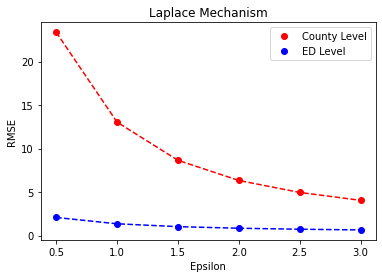

In [77]:
plt.plot(epsilons, all_county_rmse, 'ro', label='County Level')
plt.plot(epsilons, all_county_rmse, 'r--')

plt.plot(epsilons, all_ed_rmse, 'bo', label='ED Level')
plt.plot(epsilons, all_ed_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('Laplace Mechanism')
plt.legend(loc="upper right")
plt.savefig("Laplace Mechanism")

In [78]:
all_ed_elapsed_time
# [17.50199317932129,
#  18.108491897583008,
#  16.809667825698853,
#  16.862422943115234,
#  16.90863585472107,
#  16.915222883224487]

[17.50199317932129,
 18.108491897583008,
 16.809667825698853,
 16.862422943115234,
 16.90863585472107,
 16.915222883224487]

In [79]:
ed_mean_time  = np.mean(all_ed_elapsed_time)
ed_mean_time # in seconds 
#17.18440576394399


17.18440576394399

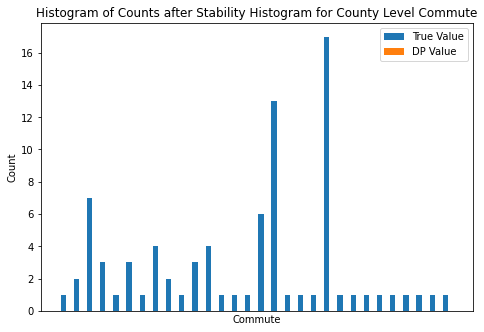

In [80]:
plot_histogram(ed_sensitive_counts[100:130], as_array(all_ed_released_counts[0])[100:130])
#plt.savefig("Histogram of Counts after Laplace Mechanism for ED")

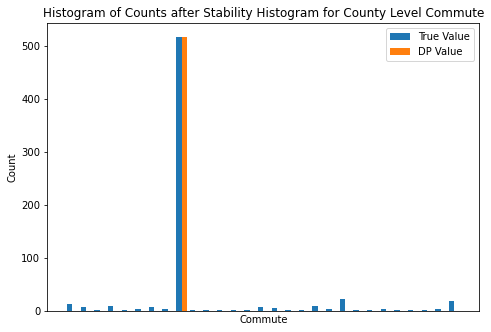

In [83]:
plot_histogram(ed_sensitive_counts[1:30], as_array(all_ed_released_counts[0])[1:30])


In [93]:
ordered = as_array(all_ed_released_counts[0])
ordered.sort(reverse = True)

In [105]:
ordered[5000:6000]
#lowest count is 76

[83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,


In [110]:
#number of zeros
count_zero = len(ordered) - np.count_nonzero(ordered)
count_zero # 8693989
nonzero =np.count_nonzero(ordered)
nonzero #5669 (example could tell you about most popular routes in a very quick time)

5669

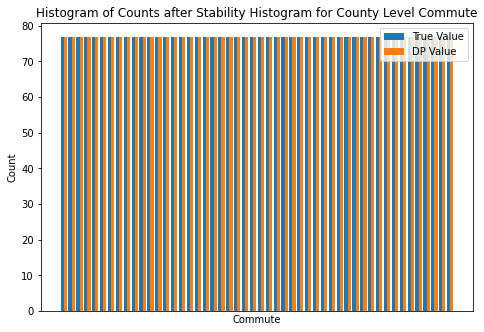

In [104]:
plot_histogram(ordered[5600:5650], ordered[5600:5550])

In [ ]:
all_ed_released_counts[0][100:130]

In [32]:
#print("Sensitive Counts :/n", ed_sensitive_counts[100:130])
#print("Released Counts :/n", all_ed_released_counts[0][100:130])
print("ed_categories :/n", ed_categories[100:130])
#ed_categories :/n ['Carlow Urban-Kilcock', 'Carlow Urban-Leixlip', 'Carlow Urban-Maynooth', 'Carlow Urban-Ballysax East', 'Carlow Urban-Carnalway', 'Carlow Urban-Droichead Nua (Newbridge) Urban', 'Carlow Urban-Kilcullen', 'Carlow Urban-Kildare', 'Carlow Urban-Kill', 'Carlow Urban-Killashee', 'Carlow Urban-Ladytown', 'Carlow Urban-Morristownbiller', 'Carlow Urban-Naas Rural', 'Carlow Urban-Oldconnell', 'Carlow Urban-Rathmore', 'Carlow Urban-Kilkenny No. 1 Urban', 'Carlow Urban-Kilkenny No. 2 Urban', 'Carlow Urban-Ballyragget', 'Carlow Urban-Castlecomer', 'Carlow Urban-Gowran', 'Carlow Urban-Kilkenny Rural', 'Carlow Urban-Shankill', 'Carlow Urban-Ballyhale', 'Carlow Urban-Goresbridge', 'Carlow Urban-Graiguenamanagh', 'Carlow Urban-Stonyford', 'Carlow Urban-Kilculliheen (part)', 'Carlow Urban-Rathpatrick', 'Carlow Urban-Abbeyleix', 'Carlow Urban-Ballinakill']

ed_categories :/n ['Carlow Urban-Kilcock', 'Carlow Urban-Leixlip', 'Carlow Urban-Maynooth', 'Carlow Urban-Ballysax East', 'Carlow Urban-Carnalway', 'Carlow Urban-Droichead Nua (Newbridge) Urban', 'Carlow Urban-Kilcullen', 'Carlow Urban-Kildare', 'Carlow Urban-Kill', 'Carlow Urban-Killashee', 'Carlow Urban-Ladytown', 'Carlow Urban-Morristownbiller', 'Carlow Urban-Naas Rural', 'Carlow Urban-Oldconnell', 'Carlow Urban-Rathmore', 'Carlow Urban-Kilkenny No. 1 Urban', 'Carlow Urban-Kilkenny No. 2 Urban', 'Carlow Urban-Ballyragget', 'Carlow Urban-Castlecomer', 'Carlow Urban-Gowran', 'Carlow Urban-Kilkenny Rural', 'Carlow Urban-Shankill', 'Carlow Urban-Ballyhale', 'Carlow Urban-Goresbridge', 'Carlow Urban-Graiguenamanagh', 'Carlow Urban-Stonyford', 'Carlow Urban-Kilculliheen (part)', 'Carlow Urban-Rathpatrick', 'Carlow Urban-Abbeyleix', 'Carlow Urban-Ballinakill']


In [38]:
label_df = agg_ed_data_df.loc[agg_ed_data_df['ED_Commute'].isin(['Carlow Urban-Kilcock', 'Carlow Urban-Leixlip', 'Carlow Urban-Maynooth', 'Carlow Urban-Ballysax East', 'Carlow Urban-Carnalway', 'Carlow Urban-Droichead Nua (Newbridge) Urban', 'Carlow Urban-Kilcullen', 'Carlow Urban-Kildare', 'Carlow Urban-Kill', 'Carlow Urban-Killashee', 'Carlow Urban-Ladytown', 'Carlow Urban-Morristownbiller', 'Carlow Urban-Naas Rural', 'Carlow Urban-Oldconnell', 'Carlow Urban-Rathmore', 'Carlow Urban-Kilkenny No. 1 Urban', 'Carlow Urban-Kilkenny No. 2 Urban', 'Carlow Urban-Ballyragget', 'Carlow Urban-Castlecomer', 'Carlow Urban-Gowran', 'Carlow Urban-Kilkenny Rural', 'Carlow Urban-Shankill', 'Carlow Urban-Ballyhale', 'Carlow Urban-Goresbridge', 'Carlow Urban-Graiguenamanagh', 'Carlow Urban-Stonyford', 'Carlow Urban-Kilculliheen (part)', 'Carlow Urban-Rathpatrick', 'Carlow Urban-Abbeyleix', 'Carlow Urban-Ballinakill'])]


In [39]:
label_df

,ED_Commute,Origin_ED,Destination_ED,EDCommute_Count
100,Carlow Urban-Kilcock,Carlow Urban,Kilcock,1.0
101,Carlow Urban-Leixlip,Carlow Urban,Leixlip,2.0
102,Carlow Urban-Maynooth,Carlow Urban,Maynooth,7.0
103,Carlow Urban-Ballysax East,Carlow Urban,Ballysax East,3.0
104,Carlow Urban-Carnalway,Carlow Urban,Carnalway,1.0
105,Carlow Urban-Droichead Nua (Newbridge) Urban,Carlow Urban,Droichead Nua (Newbridge) Urban,3.0
106,Carlow Urban-Kilcullen,Carlow Urban,Kilcullen,1.0
107,Carlow Urban-Kildare,Carlow Urban,Kildare,4.0
108,Carlow Urban-Kill,Carlow Urban,Kill,2.0
109,Carlow Urban-Killashee,Carlow Urban,Killashee,1.0


In [20]:
len(sensitive_counts)

8699659

In [ ]:
plot_histogram(sensitive_counts[0:50], as_array(released_counts)[0:50])